In [1]:
# Environment Variables: 

YES = 1
NO = 0

In [3]:
# Imports for Training
check_GPU = NO

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm
import tensorflow as tf

%matplotlib inline
output_scaler = StandardScaler()
if(check_GPU):
    print(tf.config.list_physical_devices('GPU'))

In [4]:
# Read H5 Data File:
data_dir = '/mnt/Research/Data/' # Change to your DATA PATH

RHEED_data_file = data_dir + 'RHEED_4848_test6.h5'
spot = 'spot_2'
h5 = h5py.File(RHEED_data_file, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)


print(f'[Normalized Images Shape]: {raw_data.shape}')

[Normalized Images Shape]: (150985, 48, 48)


[Normalized Image #55153]:


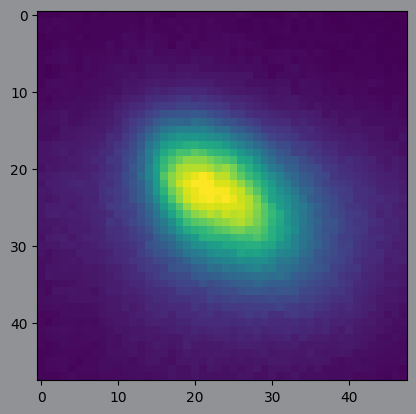

In [7]:
# Validate Data Array:
validate_data_array = YES

if validate_data_array:
    rand_int = np.random.randint(low=0, high=raw_data.shape[0])
    print(f'[Normalized Image #{rand_int}]:')
    plt.imshow(raw_data[rand_int])

In [8]:
# Estimate Labels:
load_labels = YES # (Takes <1 min to load, ~40 mins to generate)

# Import From File
if load_labels:
    RHEED_label_file = data_dir + 'Estimated_Labels_!NormalizedImages.npy'
    estimated_labels = np.load(RHEED_label_file)

# Generate

print(f'[Estimated Labels Shape]: {estimated_labels.shape}')

[Estimated Labels Shape]: (150985, 5)


In [10]:
# Create DataSet:
batch_size = 1000

with tf.device('CPU'):
    dataset = tf.data.Dataset.from_tensor_slices(raw_data)
    dataset = dataset.shuffle(raw_data.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)

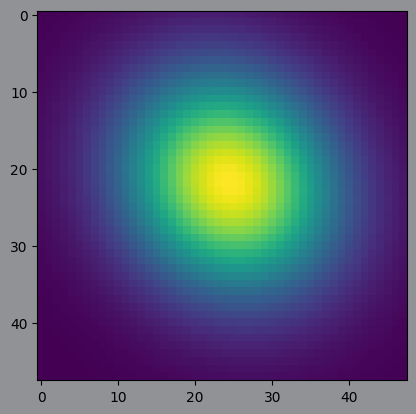

In [17]:
# Gaussian Function: (TENSORFLOW)
print_example_guassian = YES

# mean_x, mean_y, cov_x, cov_y, theta
def generate_guassian(batch, image_shape):
    batch_size = batch.shape[0]
    mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(batch, axis=-1)
    x = tf.range(image_shape[1], dtype=tf.float32)[:, tf.newaxis]
    x = tf.tile(x, [1, image_shape[0]])

    y = tf.range(image_shape[0], dtype=tf.float32)[tf.newaxis, :]
    y = tf.tile(y, [image_shape[1], 1])

    x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
    y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])

    rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
    rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

    xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
    xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / tf.reshape(cov_x, (-1, 1, 1))**2 + xy[:, :, :, 1]**2 / tf.reshape(cov_y, (-1, 1, 1))**2))

    return tf.expand_dims(img, axis=-1) # if (batch_size, height, width, channels)
    # return tf.expand_dims(img, axis=1) # 1 if (batch_size, channels, height, width)

if print_example_guassian:
    image_shape = (48, 48)
    batch = estimated_labels[:5, :]
    generated_imgs = generate_guassian(batch, image_shape)
    plt.imshow(tf.squeeze(generated_imgs[0]))
    plt.show()

In [19]:
# Custom Loss Function (TENSORFLOW):
print_example_loss = NO

def custom_weighted_mse_loss(I, J, n):
  W = tf.pow(I, n)

  squared_diffs = tf.pow(I - J, 2)

  weighted_squared_diffs = W * squared_diffs

  loss = tf.reduce_mean(weighted_squared_diffs)

  return loss

if print_example_loss:
  I = tf.random.normal((5, 1, 48, 48))
  J = tf.random.normal((5, 1, 48, 48))
  n = 2
  loss = custom_weighted_mse_loss(I, J, n)
  print("[Custom Weighted MSE Loss]:", loss.numpy())

In [20]:
# Model Architecture

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid'),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05),  # if (batch_size, height, width, channels)
        # tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05), # if (batch_size, channels, height, width)
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=4, strides=4),

        tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid'),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05), # if (batch_size, height, width, channels)
        # tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05), # if (batch_size, channels, height, width)
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=98, activation='relu'),
        tf.keras.layers.Dense(units=52, activation='relu'),
        tf.keras.layers.Dense(units=5)
    ]
)

model.compile(optimizer='adam', loss=custom_weighted_mse_loss)

In [21]:
# Training Loop
train_model = YES
save_model = NO
load_model = NO
model_summary = YES
Gaussian_Model_dir = data_dir + 'Models/'
Gaussian_Model_file = Gaussian_Model_dir + 'Gaussian_Model.keras'

if train_model:
    best_loss = float('inf')
    num_epochs = 200
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            image_batch = tf.expand_dims(image_batch, axis=-1) # if (batch_size, height, width, channels)
            # image_batch = tf.expand_dims(image_batch, axis=1) # if (batch_size, channels, height, width)
            with tf.GradientTape() as tape:
                embedding = model(image_batch)
                final = generate_guassian(embedding, (48,48))
                loss = custom_weighted_mse_loss(image_batch, final, n)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

if (save_model and not load_model):
    model.save(Gaussian_Model_file)

if (load_model and not save_model):
    with tf.keras.utils.custom_object_scope({'custom_weighted_mse_loss': custom_weighted_mse_loss}):
        model = tf.keras.models.load_model(Gaussian_Model_file)

if model_summary:
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 44, 44, 6)         156       
                                                                 
 batch_normalization_2 (Batc  (None, 44, 44, 6)        24        
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 16)          2416      
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 16)        

In [22]:
# Imports for Synthesizing

In [24]:
# Generate Plausible Gaussians for Validation:
num_generated_gaussians = 1000

avg_params = np.mean(estimated_labels, axis=0) # output_scaler.mean_ ?
std_params = np.std(estimated_labels, axis=0) # output_scaler.var_ ?

generated_gaussians_labels = []
for num in range(num_generated_gaussians):
    new_gaussian_label = []
    for (avg, std) in zip(avg_params, std_params):
        new_gaussian_label.append(avg + np.random.normal(loc=0, scale=std))
    generated_gaussians_labels.append(new_gaussian_label)
generated_gaussians_labels = np.array(generated_gaussians_labels)

generated_gaussians_images = generate_guassian(tf.convert_to_tensor(generated_gaussians_labels, dtype=tf.float32), (48,48))

print(f'[Generated Gaussian Labels Shape]: {generated_gaussians_labels.shape}')
print(f'[Generated Guassian Images Shape]: {generated_gaussians_images.shape}')

[Generated Gaussian Labels Shape]: (1000, 5)
[Generated Guassian Images Shape]: (1000, 48, 48, 1)


[True Label #677]:      [21.717394   24.43556    10.53981    -9.251635   -0.72040236]
[Predicted Label #677]: [-209.05905 -347.68973 3122.35    4012.7866   191.17494]


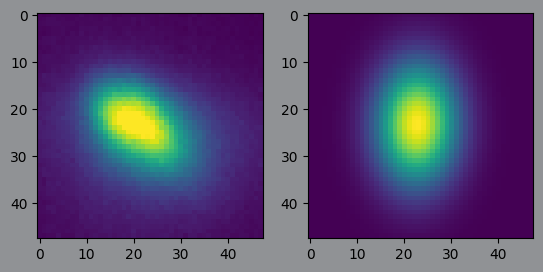

In [38]:
# Unquantized Gaussian Validation

predicted_gaussian_labels = np.array(model(raw_data[:1000])) * std_params + avg_params
predicted_gaussians_images = generate_guassian(tf.convert_to_tensor(generated_gaussians_labels, dtype=tf.float32), (48,48))

rand_int = np.random.randint(low=0, high=num_generated_gaussians)
# print(f'[Gaussian_Model MSE]: {mean_squared_error(generated_gaussians_labels, predicted_gaussian_labels)}')
# print(f'[Gaussian_Model MAE]: {mean_absolute_error(generated_gaussians_labels, predicted_gaussian_labels)}')
print(f'[True Label #{rand_int}]:      {estimated_labels[rand_int]}')
print(f'[Predicted Label #{rand_int}]: {predicted_gaussian_labels[rand_int]}')

plt.subplot(1, 2, 1)
plt.imshow(raw_data[rand_int])
plt.subplot(1, 2, 2)
plt.imshow(predicted_gaussians_images[rand_int])
plt.show()